# Evaluation of A **Regression** Model

This notebook is intended to be used for evaluation of a trained regression model over test dataset. Please change the config dictionary in the begening so that you can evaluate your desired model/sample etc...

In [1]:
#configure your evalutaion parameters here
_config = {
    'batch_size':1,
    'input_shape_height' : 375,
    'input_shape_width' : 262,
    'model_filename' : 'output/resnet_regrerssion/model.h5',
    'test_sample_filename' : 'data/test/00000000a9764df2_20191005_085442_4.png'
}

In [2]:
#If you want to disable GPU uncomment here
#import os 
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.resnet_v2 import preprocess_input

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    _ = tf.config.experimental.set_memory_growth(physical_devices[0], True)

df_train =  pd.read_csv('data/train_labels.csv')
df_test =  pd.read_csv('data/test_labels.csv')

from helpers.decouple import decouple
matrix_test,classes_test = decouple(df_test)
matrix_train,classes_train = decouple(df_train)
from helpers.matrix_to_df import matrix_to_dfcount
df_test_agg = matrix_to_dfcount(matrix_test)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test_agg,
        directory='data/test',
        x_col='filename',
        y_col='count',
        target_size=(_config['input_shape_height'], _config['input_shape_width']),
        batch_size=_config['batch_size'],
        class_mode='raw')

model = load_model(_config['model_filename'],compile=False)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Using TensorFlow backend.
Found 505 validated image filenames.


In [4]:
model.evaluate_generator(test_generator)

[0.03913490101695061, 0.5643564462661743]

---
This section is intented to examine a single random image from the image data generator. Let me explain the plots in detail.

- First we visaully see the sample.
- In the bottom of the image we see bar chart where in the x axis we see the every product label. For each class/product we plot 3 bars.
    - blue bar is the actual score that the model predicted.
    - orange is the rounded number of the regresion score.
    - green is the ground truth. It shows the true number of objects in the image


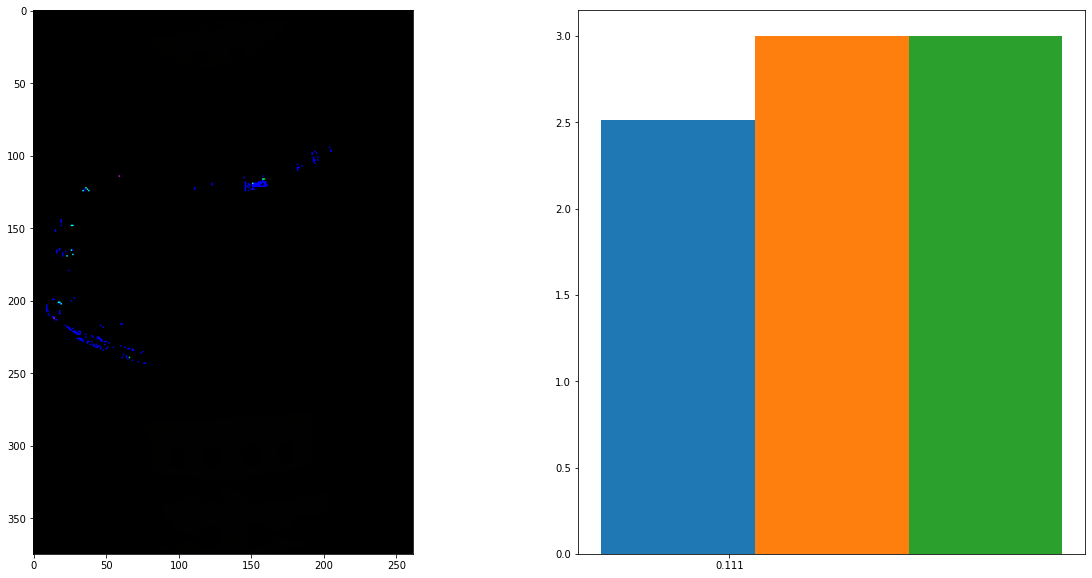

In [5]:
img_batch,ground_truth = test_generator.next()
test_img_visible = img_batch[0].astype('uint8')
prediction = model.predict(img_batch)
prediction_rounded = np.round(prediction)

fig, ax = plt.subplots(1,2,figsize=(20,10))

#visualization of sample
ax[0].imshow(test_img_visible)

#barchart of prediction binary prediction and ground truth
dim = 3
w = 1
dimw = w / dim
x = np.arange(1)
ax[1].bar(x+0*dimw, list(prediction[0]),dimw)
ax[1].bar(x+1*dimw, list(prediction_rounded[0]),dimw)
ax[1].bar(x+2*dimw, ground_truth[0],dimw)
ax[1].set_xticks(x + dimw / 3) 
plt.show()